In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from io import BytesIO
from IPython.display import display
import statsmodels.api as sm
import os
from datetime import datetime
from PIL import Image
import shutil
import string
from functions import functions 

In [2]:
def algorithm_analyze(code_str, input_type):

    pol_degree = 4

    def get_function_object(code_str):
        local_scope = {}
        
        # Execute the function definon in a scope where it can recursively reference itself
        exec(code_str, local_scope, local_scope)  # Using local_scope as both global and local scope
        
        func_name = next(key for key, value in local_scope.items() if callable(value))
        algorithm = local_scope[func_name]
        
        return algorithm



    def get_graph(function, input_type):
        if input_type == 'array':
            sizes, test_input = array_input()
            
        if input_type == 'matrix':
            sizes, test_input = matrix_input()

        if input_type == 'string with letters only':
            sizes, test_input = letter_string_input()

        if input_type == 'string with all characters':
            sizes, test_input = all_string_input()

        if input_type == 'plain graph matrix':
            sizes, test_input = graph_matrix_input()
            
        times = measure_times(function, test_input)

            # Fit a polynomial curve to the data
        coefficients = np.polyfit(sizes, times, deg=pol_degree)  # Degree 4 polynomial
        poly = np.poly1d(coefficients)

        # Generate smooth data for the fitted curve
        smooth_sizes = np.linspace(min(sizes), max(sizes), 500)  # Smooth sizes from min to max size
        smooth_times = poly(smooth_sizes)  # Evaluate polynomial

        plt.figure()
        plt.plot(sizes, times, 'o', markersize=3, label='Original Data', color='white')  # Original data points
        plt.plot(smooth_sizes, smooth_times, 'r-', label='Fitted Curve')  # Fitted curve
        plt.axis('off')  # Hide the axes

        # Save the plot to a BytesIO stream
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to free memory
        buf.seek(0)  # Rewind your buffer
        return buf, coefficients.tolist()
    


    def array_input(n_size=700, a_size=500):
        sizes = list(range(1, n_size))
        test_lists = []

        for size in sizes:
            test_list = [random.randint(0, a_size) for _ in range(size)]
            test_lists.append(test_list)

        return sizes, test_lists
    
    def matrix_input(n_size=500, a_size=200):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def graph_matrix_input(n_size=500, a_size=1):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def letter_string_input(n_size=5000):
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join([random.choice('abcdefghijklmnopqrstuvwxyz') for _ in range(size)])
            test_strings.append(test_string)
        
        return sizes, test_strings
    
    def all_string_input(n_size=5000):
        char_pool = string.ascii_letters + string.digits + string.punctuation
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join(random.choice(char_pool) for _ in range(size))
            test_strings.append(test_string)

        return sizes, test_strings

    def measure_times(function, test_input):
        times = []

        for test_list in test_input:
            start_time = time.perf_counter()
            function(test_list)
            end_time = time.perf_counter()

            elapsed_time = end_time - start_time
            times.append(elapsed_time)

        return times

    
    algorithm = get_function_object(code_str)
    buf, coefficients = get_graph(algorithm, input_type)
    return buf, coefficients



In [3]:
def save_algorithm_output(code_str, input_type, complexity_type, repeat):
    # Ensure the directory exists
    images_dir = f'images/{complexity_type}'
    os.makedirs(images_dir, exist_ok=True)  # Creates the directory if it doesn't exist
    
    csv_path = 'features.csv'
    
    # Initialize a DataFrame to collect all coefficients and file paths
    all_coefficients = pd.DataFrame()
    
    # Process and save each output
    for i in range(repeat):
        image_bytes, coefficients = algorithm_analyze(code_str, input_type)
        
        # Create a unique timestamp
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S%f')
        
        # Save image with a unique timestamp in the filename
        image_filename = f"{images_dir}/image_{timestamp}.png"
        with open(image_filename, 'wb') as f:
            f.write(image_bytes.getbuffer())
        
        # Convert coefficients to DataFrame, ensuring they're labeled correctly
        # Here we dynamically create column names based on the length of coefficients list
        coeff_columns = [f'Coeff_{j}' for j in range(len(coefficients))]
        df = pd.DataFrame([coefficients], columns=coeff_columns)
        df['ImageFile'] = image_filename  # Track image file name
        
        # Append the current row of coefficients to the all_coefficients DataFrame
        all_coefficients = pd.concat([all_coefficients, df], ignore_index=True)
    
    # Save or append the coefficients data to CSV
    if os.path.exists(csv_path):
        all_coefficients.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        all_coefficients.to_csv(csv_path, mode='w', index=False)

    return all_coefficients  # Optional: return DataFrame for further processing or inspection

# Example call (You need to define or adjust `algorithm_analyze` as per your actual implementation)
# save_algorithm_output('some_code_str', 'type1', 'simple', 10)


In [4]:
def clean_images():
    directory= 'images'
    # Loop through all items in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            # If it's a file or directory, remove it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

def clear_csv_file():
    file_path = 'features.csv'
    # Open the file in write mode which will truncate the file (set it to empty)
    with open(file_path, 'w', newline='') as csv_file:
        pass






In [19]:
func_type = 'nlog(n)'
input_type = 'array'
index = 2
function_x = functions[func_type][input_type][index]
function_x



'\n\ndef heap_sort(arr):\n    n = len(arr)\n\n    # Build max heap\n    for i in range(n // 2 - 1, -1, -1):\n        # Heapify in place without a helper function\n        largest = i\n        while True:\n            left = 2 * largest + 1\n            right = 2 * largest + 2\n            new_largest = largest\n\n            if left < n and arr[left] > arr[new_largest]:\n                new_largest = left\n            if right < n and arr[right] > arr[new_largest]:\n                new_largest = right\n\n            if new_largest == largest:\n                break\n\n            arr[largest], arr[new_largest] = arr[new_largest], arr[largest]\n            largest = new_largest\n\n    # Extract elements one by one\n    for i in range(n-1, 0, -1):\n        # Move current root to end\n        arr[i], arr[0] = arr[0], arr[i]\n\n        # Heapify the reduced heap\n        largest = 0\n        while True:\n            left = 2 * largest + 1\n            right = 2 * largest + 2\n            n

## Diplay and generate data

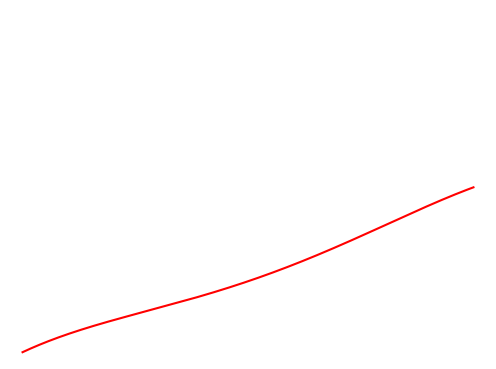

Coefficients: [-6.096917141011129e-15, 9.270596850828062e-12, -4.013091498900102e-09, 1.6014253225627013e-06, -1.8905559307269044e-05]
<class '_io.BytesIO'>


In [21]:
buf, coefficients = algorithm_analyze(function_x, input_type)
image = Image.open(buf)

# Display the image in the notebook
display(image)
print("Coefficients:", coefficients)
print(type(buf))

## Generate and save data for training

In [35]:
save_algorithm_output(function_x, 'array', func_type,  1)

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,ImageFile
0,1.558984e-17,-2.482618e-14,1.359423e-11,-2.990295e-09,3.879827e-07,images/constant/image_20240914235833022729.png


## Delete generated data

In [33]:
clean_images()

In [34]:
clear_csv_file()

## Generate 1000 data units

In [36]:
for func_type in functions:
    for input_type in functions[func_type]:
        for function_x in functions[func_type][input_type]:
            save_algorithm_output(function_x, input_type, func_type, 1)

        

KeyboardInterrupt: 